In [181]:
import pandas as pd
import numpy as np
import pickle
import codecs
import time
from itertools import chain
from collections import Counter

import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from gensim.models import word2vec
from gensim.models import FastText
from gensim.test.utils import get_tmpfile

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

import sys
sys.path.append("util")
from util.text_preprocessing import preprocess
from util.load_data import load_word2vec

from tensorflow import keras

# Reference

- Kim, Y. (2014). Convolutional neural networks for sentence classification. arXiv preprint arXiv:1408.5882.

<img src = "자료/textCNN model architecture.png" width="800" align="center" ></img>>

# 1. 감정 댓글 불러오기

In [2]:
word2vec_path = "dataset/embedding_model/0710 w2v_model"
data_path = 'dataset/final_data/0710 comment_with_emo_over0.5.pkl'

In [3]:
emotion_comment_df = pd.read_pickle(data_path)
    
print("emotion_comment_df: ", emotion_comment_df.shape)
display(emotion_comment_df.sample(5))

emotion_comment_df:  (408607, 11)


,happy,sad,disgust,angry,surprised,fear,comment_id,comment,comment_token,check,emotion
1225235,0.0,0.0,1.0,0.0,0.0,0.0,B352DA0BB0AB45689E1904A668E4E70B,연합 정말 실망이네. 아베가 먼저하고 트럼프가 따라하는데..,"[연합, 정말, 실망, 아베, 먼저, 트럼프, 따르다]",[실망],disgust
123565,0.0,1.0,0.0,0.0,0.0,0.0,56A6AC3C9C824715A643EB5B4F1D84C8,지금 북한보다 이스라엘 상황이 더 심각한거 같은데??,"[지금, 북한, 이스라엘, 상황, 더, 심각하다, 같다]",[심각하다],sad
881538,0.0,0.0,0.0,1.0,0.0,0.0,94010587120A49C19C26E78959FA1A5B,꺼져!,[꺼지다],[꺼지다],angry
1026902,0.0,1.0,0.0,0.0,0.0,0.0,04495624FD9C4E4DA446FA8F0E6BAE19,미안하면 젊은사람 자리나 뺏지말던가 젊은사람들 염장지르나 염병할,"[미안하다, 젊다, 사람, 자리, 뺏다, 젊다, 사람, 염장, 지르다, 염병할]",[미안하다],sad
944276,0.0,0.0,0.0,1.0,0.0,0.0,FDAF8B171AE8496AA1F7B2A9AC792037,개돼지만도 못한 인간쓰레기... 이런 쓰레기를 감싸면 똑같겠죠?,"[개돼지, 못, 인간, 쓰레기, 이렇다, 쓰레기, 감싸다, 똑같다]","[쓰레기, 쓰레기]",angry


In [4]:
print("샘플링 전 :",Counter(emotion_comment_df.emotion))
print()

# 각 감정별로 셔플한 다음 8,000개씩 부여 (Train = 85% / Test = 15%)
sample_count = 8000

sampled_emo_cmt_df = (
    emotion_comment_df.groupby('emotion').apply(
        lambda d: shuffle(d, random_state=42, n_samples=sample_count)).reset_index(drop=True)
)

print("샘플링 이후 :",Counter(sampled_emo_cmt_df.emotion))

샘플링 전 : Counter({'angry': 240971, 'sad': 83041, 'happy': 44682, 'disgust': 17263, 'fear': 14649, 'surprised': 8001})

샘플링 이후 : Counter({'angry': 8000, 'disgust': 8000, 'fear': 8000, 'happy': 8000, 'sad': 8000, 'surprised': 8000})


**균등한 데이터셋 분포를 위해 사전에 감정 별 데이터 크기를 동일하게 맞춤**

# 2. Text Encoding

- 모든 단어를 정수로 인코딩
- 케라스의 `Tokenizer` 클래스 사용
- 모든 단어를 각기 다른 단어 ID에 매핑. ID는 1부터 시작해 고유한 단어 개수까지 생성 (**마스킹에 사용하기 때문에 0부터 시작하지 않음**)

In [5]:
emotion_token_list = sampled_emo_cmt_df["comment_token"].tolist()


# 모든 글자를 정수 ID로 인코딩
def word_to_id(token_list):
    print("sample data : ",token_list[0])
    tokenizer = keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(token_list)
    print("texts to sequences ===>",tokenizer.texts_to_sequences([token_list[0]]))
    print("sequences to texts ===>",tokenizer.sequences_to_texts([[1,2,3,4,5]])) 
    print()
    
    word_to_id = tokenizer.word_index
    id_to_word = tokenizer.index_word
    
    print("고유 단어 개수 : {}, 전체 댓글 개수 : {}".format(len(word_to_id), tokenizer.document_count))
    
    encoded_tokens = []
    for token in token_list:
        encoded_tokens.append(tokenizer.texts_to_sequences([token])[0])
    
    return encoded_tokens, word_to_id, id_to_word
    
encoded_tokens, word_to_id, id_to_word = word_to_id(emotion_token_list)

sample data :  ['멀다', '놈', '기사', '도통', '내용', '뭐', '알다', '없다']
texts to sequences ===> [[449, 18, 52, 8897, 729, 35, 28, 3]]
sequences to texts ===> ['있다 되다 없다 보다 아니다']

고유 단어 개수 : 35670, 전체 댓글 개수 : 48000


In [110]:
# X (padding)

MAX_SEQUENCE_LENGTH = 20

data = keras.preprocessing.sequence.pad_sequences(encoded_tokens, maxlen=MAX_SEQUENCE_LENGTH)

# y (one-hot encoding labels)

cat_encoder = OneHotEncoder()
labels = cat_encoder.fit_transform(sampled_emo_cmt_df[['emotion']]).toarray()

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
print()
print(cat_encoder.categories_)
print(labels)

Shape of data tensor: (48000, 20)
Shape of label tensor: (48000, 6)

[array(['angry', 'disgust', 'fear', 'happy', 'sad', 'surprised'],
      dtype=object)]
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


# 3.Embedding Matrix 만들기 

In [111]:
w2v_model = load_word2vec(word2vec_path)

word2vec 모델 불러오기 ... finished in 7.49 sec.
#words = 168620, vector size = 300


In [112]:
# with pretrained model
def create_embedding_matrix(w2v_model, word_to_id):
    '''
    pretrained model이 존재할 때 embedding matrix 만드는법
    if 존재하지 않는다면, keras.Embedding layer 사용
    '''
    
    EMBEDDING_DIM = w2v_model.vector_size

    embedding_matrix = np.zeros((len(word_to_id)+1, EMBEDDING_DIM))
    print(embedding_matrix.shape)

    for word, i in word_to_id.items():
        try:
            embedding_vector = w2v_model.wv[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            embedding_matrix[i] = np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)
            
    return embedding_matrix

In [113]:
embedding_matrix = create_embedding_matrix(w2v_model, word_to_id)
embedding_matrix

(35671, 300)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.13877146, -0.03067526, -0.07808419, ..., -0.05337833,
        -0.0992438 , -0.00218738],
       [-0.03504737, -0.12057228,  0.01615535, ...,  0.005222  ,
        -0.08698165,  0.06102141],
       ...,
       [ 0.04774499,  0.08327273,  0.00324909, ..., -0.05244453,
        -0.05709571, -0.09028624],
       [-0.05991533, -0.03845508, -0.01238701, ..., -0.00123169,
        -0.07324471, -0.04061742],
       [-0.11260591, -0.00158114,  0.01082337, ...,  0.00661842,
        -0.05145192, -0.09587358]])

In [126]:
# shuffle data 

indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]
labels = labels[indices]

# split the data into a training set and a validation set 

VALIDATION_SPLIT = 0.2
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

split_idx = int(len(data)*split_frac)
X_train, remaining_x = data[:split_idx], data[split_idx:]
y_train, remaining_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
X_val, X_test = remaining_x[:test_idx], remaining_x[test_idx:]
y_val, y_test = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(X_train.shape), 
      "\nValidation set: \t{}".format(X_val.shape),
      "\nTest set: \t\t{}".format(X_test.shape))

			Feature Shapes:
Train set: 		(38400, 20) 
Validation set: 	(4800, 20) 
Test set: 		(4800, 20)


# 4. CNN 학습

In [98]:
EMBEDDING_DIM = 300
MAX_SEQUENCE_LEGNTH = 20
filter_sizes = [3,4,5]
num_filters = 100
dim_output = 6

class textCNN(keras.Model):
    
    def __init__(self,
                 embedding_matrix,
                 output_size=dim_output,
                 max_sequence_length=MAX_SEQUENCE_LENGTH,
                 num_filters=100,
                 filter_sizes=[3,4,5],
                 drop_prob=0.5,
                 train_embedding=False, # Note that we set trainable=False to prevent the weights from being updated during training.
                 **kwargs):
        super(textCNN,self).__init__(**kwargs) # 표준 매개변수 처리
        
        self.max_sequence_length = max_sequence_length
        self.drop_prob = drop_prob
        self.num_filters = num_filters
        self.filter_sizes = filter_sizes
        self.output_size = output_size

        vocab_size, embedding_dim = embedding_matrix.shape
        
        #### layers
        # if using pretrained model to initialize
        self.embedding_layer = keras.layers.Embedding(vocab_size,
                                                    EMBEDDING_DIM,
                                                    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                                                    trainable=train_embedding) 

        # # if not using pretrained model
        # self.embedding_layer = keras.layers.Embedding(len(word_to_id) + 1,
        #                                               EMBEDDING_DIM,
        #                                               input_length=MAX_SEQUENCE_LENGTH) 

        self.conv_layers = []
        for i,filter_size in enumerate(filter_sizes):
            conv_block = keras.Sequential()

            conv = keras.layers.Conv2D(num_filters,
                                       (filter_size, embedding_dim),
                                       padding='VALID', # ignore padding
                                       activation='relu',
                                       strides=(1,1),
                                       name=f'conv_layer_{i}')

            pooling = keras.layers.MaxPooling2D((max_sequence_length - filter_size + 1, 1),
                                                padding='valid',
                                                strides=(1,1),
                                                name=f'pooling_layer_{i}')    

            conv_block.add(conv)
            conv_block.add(pooling)
            
            self.conv_layers.append(conv_block)
            
        self.dense = keras.layers.Dense(output_size,
                                     activation='softmax',
                                     kernel_regularizer=keras.regularizers.l2(0.01),
                                     name='prediction')
        
        self.flatten = keras.layers.Flatten(name='flatten')
        self.reshape = keras.layers.Reshape((max_sequence_length, embedding_dim, 1))
        self.dropout = keras.layers.Dropout(rate=drop_prob, name='dropout')
        
    def call(self, inputs, training=None):
        
        embedding = self.embedding_layer(inputs)
        reshape = self.reshape(embedding) #(sequence_length,EMBEDDING_DIM,1)
        
        pool_outputs = [layer(reshape) for layer in self.conv_layers]
        pool_outputs = keras.layers.concatenate(pool_outputs, axis=-1, name='concatenate')
        pool_outputs = self.flatten(pool_outputs)
        pool_outputs = self.dropout(pool_outputs)

        if training:
            pool_outputs=self.dropout(pool_outputs)

        logit = self.dense(pool_outputs)
        
        return logit

In [99]:
cnn = textCNN(embedding_matrix = embedding_matrix,
              max_sequence_length=20,
              output_size = 6)

In [123]:
cnn.compile(loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adam(),
            metrics=['acc'])
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss')]

In [131]:
cnn.summary()

Model: "text_cnn_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     multiple                  10701300  
_________________________________________________________________
sequential_46 (Sequential)   multiple                  90100     
_________________________________________________________________
sequential_47 (Sequential)   multiple                  120100    
_________________________________________________________________
sequential_48 (Sequential)   multiple                  150100    
_________________________________________________________________
prediction (Dense)           multiple                  1806      
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
reshape_8 (Reshape)          multiple                  

In [130]:
 # starts training
history = cnn.fit(X_train, y_train,
                  batch_size=4, 
                  epochs=10, 
                  verbose=1,
                  validation_data=(X_val,y_val),
                  callbacks=callbacks) 

Epoch 1/10
9600/9600 [==============================] - 59s 6ms/step - loss: 0.6911 - acc: 0.8106 - val_loss: 0.4426 - val_acc: 0.8844
Epoch 2/10
9600/9600 [==============================] - 55s 6ms/step - loss: 0.4556 - acc: 0.8803 - val_loss: 0.3830 - val_acc: 0.8929
Epoch 3/10
9600/9600 [==============================] - 58s 6ms/step - loss: 0.3959 - acc: 0.8964 - val_loss: 0.3514 - val_acc: 0.9006
Epoch 4/10
9600/9600 [==============================] - 54s 6ms/step - loss: 0.3621 - acc: 0.9036 - val_loss: 0.3321 - val_acc: 0.9048
Epoch 5/10
9600/9600 [==============================] - 72s 8ms/step - loss: 0.3431 - acc: 0.9111 - val_loss: 0.3262 - val_acc: 0.9029
Epoch 6/10
9600/9600 [==============================] - 72s 8ms/step - loss: 0.3194 - acc: 0.9177 - val_loss: 0.3252 - val_acc: 0.9029
Epoch 7/10
9600/9600 [==============================] - 66s 7ms/step - loss: 0.3098 - acc: 0.9197 - val_loss: 0.3150 - val_acc: 0.9023
Epoch 8/10
9600/9600 [==============================] -

# 5. Result

In [132]:
# final evaluation of the model
print ("")
scores = cnn.evaluate(X_test, y_test, verbose=1)
print ("")
print ("loss: %.2f%%" % (scores[0] * 100))
print ("Accuracy: %.2f%%" % (scores[1] * 100))


150/150 [==============================] - 1s 8ms/step - loss: 0.3000 - acc: 0.9162

loss: 30.00%
Accuracy: 91.62%


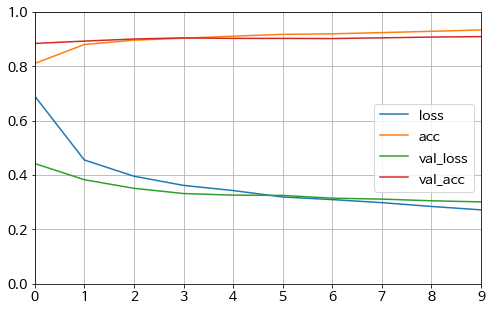

In [180]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [200]:
y_proba = cnn.predict(X_test)
print("probability")
print(y_proba.round(2))


class_names = cat_encoder.categories_[0]
y_pred = np.argmax(y_proba,axis=1)
print()
print("predict")
print(class_names[y_pred])
print()
print("감정 개수 별 예측")
print(Counter(class_names[y_pred]))

probability
[[0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.  ]
 [0.   0.   1.   0.   0.   0.  ]
 ...
 [0.   0.   0.   1.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.  ]
 [0.19 0.1  0.24 0.22 0.15 0.11]]

predict
['fear' 'sad' 'fear' ... 'happy' 'angry' 'fear']

감정 개수 별 예측
Counter({'sad': 835, 'happy': 821, 'surprised': 817, 'angry': 800, 'fear': 779, 'disgust': 748})


# Alpha
## 함수형 API

In [91]:
vocab_size, embedding_dim = embedding_matrix.shape


# functional
sequence_length = X_train.shape[1]
inputs = keras.layers.Input(shape=(max_sequence_length,))
embedding = keras.layers.Embedding(vocab_size, EMBEDDING_DIM,
                                   weights=[embedding_matrix],
                                   trainable=True)(inputs)
reshape = keras.layers.Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = keras.layers.Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',
                            kernel_regularizer=keras.regularizers.l2(0.01))(reshape)
conv_1 = keras.layers.Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',
                            kernel_regularizer=keras.regularizers.l2(0.01))(reshape)
conv_2 = keras.layers.Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM),activation='relu',
                            kernel_regularizer=keras.regularizers.l2(0.01))(reshape)

maxpool_0 = keras.layers.MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), 
                                      strides=(1,1))(conv_0)
maxpool_1 = keras.layers.MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), 
                                      strides=(1,1))(conv_1)
maxpool_2 = keras.layers.MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), 
                                      strides=(1,1))(conv_2)

# pool_outputs = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
pool_outputs = keras.layers.Concatenate()([maxpool_0, maxpool_1, maxpool_2])

flatten = keras.layers.Flatten()(pool_outputs)
dropout = keras.layers.Dropout(drop_prob)(flatten)
output = Dense(units=6, 
               activation='softmax',
               kernel_regularizer=keras.regularizers.l2(0.01))(dropout)

# this creates a model that includes
model = keras.Model(inputs, output)

# 2018ver

In [30]:
def cnn_model(dropout):   
    # gpu 설정
    with K.tf.device('/gpu:0'):
        model_Conv2 = Sequential()        

        EMBEDDING_DIM = 300
        MAX_SEQUENCE_LENGTH = 20
        
        # 3 Conv1D layers
        model_Conv2.add(Embedding(len(word_index),
                        EMBEDDING_DIM,
                        weights = [embedding_matrix],
                        input_length = MAX_SEQUENCE_LENGTH,
                        trainable = False) )
        
        model_Conv2.add(Conv1D(256,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv2.add(Dropout(dropout))
        
        model_Conv2.add(Conv1D(256,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv2.add(Dropout(dropout))
        
        model_Conv2.add(Conv1D(256,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv2.add(Dropout(dropout))

        model_Conv2.add(GlobalMaxPooling1D())
        
        model_Conv2.add(Dense(256, activation='relu'))
        model_Conv2.add(Dropout(dropout))
        
        model_Conv2.add(Dense(64, activation='relu'))
        model_Conv2.add(Dropout(dropout))

        model_Conv2.add(Dense(6, activation='softmax'))
        
        # optimizer 사용
        Adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
        
        model_Conv2.compile(
            loss = 'categorical_crossentropy',
            optimizer = Adam,
            metrics = ['accuracy'])
        
        model_Conv2.summary()
        # Model 학습, tensorflow chart 활용
        # tb_hist = keras.callbacks.TensorBoard(log_dir = './graph', histogram_freq = 0, 
        #                                           write_graph = True, write_images = True)
        conv_model2 = model_Conv2.fit(
            X_train, y_train,
            epochs = 200, batch_size = 64,
            validation_split = 0.1,#0.1로 고정할 것
            callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10)], # tb_hist
            verbose = 1,
            shuffle=True)

        # final evaluation of the model
        print ("")
        scores = model_Conv2.evaluate(X_test, y_test, verbose=1)
        print ("")
        print ("loss: %.2f%%" % (scores[0] * 100))
        print ("Accuracy: %.2f%%" % (scores[1] * 100))

        # 과정 살펴보기
        matplotlib.rcParams.update({'font.size': 12})
        fig, loss_ax = plt.subplots()
        #krkwplt.style.use("ggplot")
        acc_ax = loss_ax.twinx()

        loss_ax.plot(conv_model2.history['loss'], 'y', label= 'train loss')
        loss_ax.plot(conv_model2.history['val_loss'], 'r', label= 'val loss')

        acc_ax.plot(conv_model2.history['accuracy'], 'b', label = 'train acc')
        acc_ax.plot(conv_model2.history['val_accuracy'], 'g', label = 'val acc')

        loss_ax.set_xlabel('epoch')
        loss_ax.set_ylabel('loss')
        acc_ax.set_ylabel('accuracy')

        loss_ax.legend(loc='right')
        acc_ax.legend(loc='best')
        fig = plt.gcf()
        plt.title("CNN Model")
        plt.show()
        
        return model_Conv2